# url2vec

**class url2vec.model.urlembed.Url2Vec(urls)**

The model has to be initialized with a dictionary that associates to every URL a unique code or otherwise from  a list of URLs. The former case is preferable, because for large datasets it drops down training time.


---

    train(self, algorithm=HDBSCAN(min_cluster_size=7), use_w2v=True, use_tfidf=True, 
          e_sg=0, e_min_count=1, e_window=10, e_negative=5, e_size=48, sequences=None, 
          d_max_df=0.9, d_max_features=200000, d_min_df=0.05, d_dim_red=50, d_tfidf=True, 
          contents=None)
        
        algorithm: 
            - default = HDBSCAN(min_cluster_size=7)
            - the chosen clustering algorithm. Is invoked the fit_predict of the passed 
              object(here HDBSCAN) to return the predicted labels.

        use_w2v: 
            - default = True
            - with True word2vec is used to cluster the URLs according to their position 
              in the sequences passed (sequences argument)
            
        use_tfidf :
            - default = True
            - with True documents (contents of the URL) are tranformed into 
              document-term matrix

        e_sg:
            - default = 0
            - word2vec argument, defines the training algorithm for word2vec,
              if 0 CBOW is used. With sg=1 skipgram is used

        e_min_count:
            - default = 1
            - word2vec argument, ignore all words with total frequency lower than this

        e_window: 
            - default = 10
            - word2vec argument, is the maximum distance between the current and 
              predicted word within a sentence.

        e_negative: 
            - default = 5
            - word2vec argument, if > 0, negative sampling will be used, the int for 
              negative specifies how many “noise words” should be drawn. If set to 0,
              no negative samping is used

        e_size: 
            - default = 48
            - word2vec argument, is the dimensionality of the feature vectors

        sequences: 
            - default = None
            - word2vec argument, iterable of sentences. Each sentence is a list of words
              that will be used for training.

        d_max_d: 
            - default = 0.9
            - document argument, this is the maximum frequency within the documents a given
              feature can have to be used in the tfi-idf matrix.

        d_max_features: 
            - default = 200000

        d_min_df: 
            - default = 0.05
            - document argument, term would have to be in at least 5 of the documents 
              to be considered.

        d_dim_red: 
            - default = 50
            - document argument, is the dimensionality of the feature vectors, reduced
              TrunceteSVD (aka LSA)

        d_tfidf: 
            - default = True
            - docuement argument, with True term frequency-inverse document frequency 
              is applied to the document-term matrix obtained (from the contents argument)

        contents: 
            - default = None
            - docuement argument. Must be a dict with the URLs as keys and relevant
              page content as values

---

    test(ground_truth, pred_membership=None)
        ground_truth:
        - given the knowledge of the ground truth, it returns the confusion table 
          (aka matching matrix)
        
        pred_membership:
            - default = None
            - if train is already done the predicted labels are already stored

---

    homogeneity_score(ground_truth=None, pred_membership=None)
        ground_truth:
            - default = None
            - given the knowledge of the ground truth, it returns the homogeneity score
        
        pred_membership:
            - default = None
            - if train is already done the predicted labels are already stored

---

    completeness_score(ground_truth=None, pred_membership=None)
        ground_truth:
            - default = None
            - given the knowledge of the ground truth, it returns the completeness score
        
        pred_membership:
            - default = None
            - if train is already done the predicted labels are already stored
            
---

    v_measure_score(ground_truth=None, pred_membership=None)
        ground_truth:
            - default = None
            - given the knowledge of the ground truth, it returns the V-measure score
        
        pred_membership:
            - default = None
            - if train is already done the predicted labels are already stored
            
---

    adjusted_rand_score(ground_truth=None, pred_membership=None)
        ground_truth:
            - default = None
            - given the knowledge of the ground truth, it returns the adjusted Rand index
        
        pred_membership:
            - default = None
            - if train is already done the predicted labels are already stored
            
---

    adjusted_mutual_info_score(ground_truth=None, pred_membership=None)
        ground_truth:
            - default = None
            - given the knowledge of the ground truth, it returns the Adjusted Mutual 
              Information score
        
        pred_membership:
            - default = None
            - if train is already done the predicted labels are already stored
            
---
    silhouette_score(pred_membership=None)
        pred_membership:
            - default = None
            - if train is already done the predicted labels are already stored, 
              it returns the silouhette score



In [1]:
import os
import numpy as np
import pandas as pd
import sys
sys.path.append(os.path.abspath(".."))

import plotly.plotly as py
#from sklearn import metrics
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
#from gensim.models import Word2Vec
#from url2vec.util.metrics import *
from url2vec.util.plotter import *
from url2vec.model.urlembed import *
from url2vec.util.seqmanager import *

from __future__ import print_function
#from sklearn.decomposition import TruncatedSVD
#from sklearn.feature_extraction.text import TfidfVectorizer

### Loading files
Here we're loading all the files previously crawled.

See the [Dataset README](https://github.com/chrisPiemonte/url2vec/tree/master/dataset "Dataset") for further information.

Here we're creating a dict that associates a code to every URL (**codecontent_map**), a generator (**sequences**) that yields a sequence at each iteration and a list of "cluster membership" (**ground_truth**) for each URL passed, in order of how the dict would be iterated.

In [2]:
dir_path = os.getcwd() + "/../dataset/cs.illinois.edu_NoConstraint.words1000.depth10/"

vertex_path      = dir_path + "vertex.txt"
codecontent_map  = get_content_map(vertex_path)

map_path         = dir_path + "urlsMap.txt"
codeurl_map      = get_urlmap(map_path)

sequences_path   = dir_path + "sequenceIDs.txt"
sequences        = get_sequences(sequences_path)

gt = GroundTruth()
ground_truth = [ int(gt.get_groundtruth(codeurl_map[code])) for code in codeurl_map ]
len(ground_truth)

728

#### Training
A simple case would be like this:

Her we're passing only the sequences and the page contents, and left unchanged the remaining parameters.
By doing the training in this way, the model maps each URL to a combined vector, derived from a 48-dimensional array from the word2vec model and a 50-dimensional array from the tf-idf matrix.

In this manner we are considering both the page content of a URL and the its feature vector from the word2vec algorithm.

In [3]:
model = Url2Vec(codeurl_map)
predicted_labels = model.train(sequences=sequences, contents=codecontent_map)
len(predicted_labels)

728

Now we have the predicted labels, clustered with the HDBSCAN algorithm (default):

In [4]:
print("Clusters found with HDBSCAN:", len(set(predicted_labels)))
print(set(predicted_labels), "\n")
print(predicted_labels[:15])

print("\n\n")

Clusters found: 11
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1]) 

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]





#### Confusion table
Now we can have the confusion table by passing the ground truth:

In [5]:
conf_table = model.test(ground_truth)
pd.DataFrame(conf_table, index=set(ground_truth), columns=set(predicted_labels))

,0,1,2,3,4,5,6,7,8,9,-1
0,0,0,0,0,0,0,17,0,0,0,1
1,0,0,0,0,0,0,8,0,0,0,4
2,0,0,0,0,0,0,0,0,47,0,0
3,0,0,0,0,0,0,0,0,0,27,2
4,0,0,0,0,0,8,0,0,0,0,6
6,0,0,0,0,0,0,0,0,0,0,6
8,0,0,0,65,0,0,0,0,0,0,10
10,0,0,0,0,0,289,0,0,0,0,36
11,0,0,0,0,0,3,0,0,0,0,4
12,0,0,0,16,0,1,0,0,0,0,2


#### Other metrics
Or have other evaluation scores:

In [6]:
homogeneity     = model.homogeneity_score()
completeness    = model.completeness_score()
v_measure       = model.v_measure_score()
adj_rand        = model.adjusted_rand_score()
adj_mutual_info = model.adjusted_mutual_info_score()
silhouette      = model.silhouette_score()

pd.DataFrame({
        "Homogeneity":homogeneity, 
        "Completeness":completeness, 
        "V-Measure":v_measure, 
        "Adj Rand index":adj_rand, 
        "Adj Mutual info":adj_mutual_info, 
        "Silhouette":silhouette
    },
    index=["Model Scores"]
)

,Adj Mutual info,Adj Rand index,Completeness,Homogeneity,Silhouette,V-Measure
Model Scores,0.728361,0.741606,0.779081,0.741134,0.25745,0.759634


We can even get the two-dimensional array of the training for plotting it

In [7]:
twodim = model.two_dim()
twodim[:5]

array([[-13.28501627, -11.39754553],
       [-14.65263276, -10.58534158],
       [-14.37534255, -11.24770391],
       [-14.45707167, -11.44542262],
       [-12.87052117, -12.22153478]])

A wild plot appears:

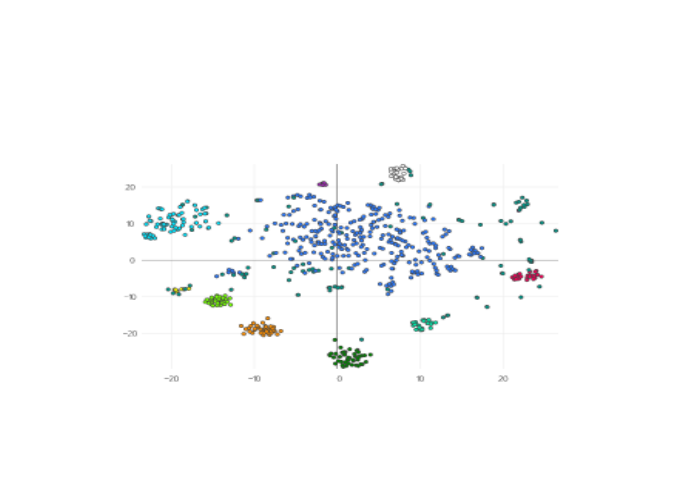

In [9]:
data = model.plot_trace()

py.image.ishow({'data': data})
# uncomment this line below (and comment the one above) to have the interactive plot
# py.iplot(data)

## A more tuned example

Ok now, we're loading all the file and creating our data structures all the way again:

In [10]:
dir_path = os.getcwd() + "/../dataset/cs.illinois.edu_NoConstraint.words1000.depth10/"

vertex_path      = dir_path + "vertex.txt"
codecontent_map  = get_content_map(vertex_path)

map_path         = dir_path + "urlsMap.txt"
codeurl_map      = get_urlmap(map_path)

sequences_path   = dir_path + "sequenceIDs.txt"
sequences        = get_sequences(sequences_path)

gt = GroundTruth()
ground_truth = [ int(gt.get_groundtruth(codeurl_map[code])) for code in codeurl_map ]
len(ground_truth)

728

Tuning some parameters:
- **algorithm** passed now is KMeans with 15 desired clusters (because of reasons)


- **e_sg** = 1 means that we ar using skip-gram for training word2vec model


- **e_min_count** = 5, we are ignorig all words with total frequency lower than 5 for training word2vec model


- **e_window** = 5, now we're considering a shorter distance (default 10) between a word and its neighboring when learning a feature vector for that word (word2vec)


- **e-size** the size of the word2vec feature vectors, or in another point of view, the importance we want to give to the URL embedding approach


- **d_dim_red** the size of the feature vectors from the tf-idf matrix(in this case), or else, the importance we want to give to the page content and the words in it.



The other parameters are listed but left unchanged. Here are set 36 for word2vec vectors and 64 for tf-idf vectors, so giving more importance to the page content.

In [11]:
model = Url2Vec(codeurl_map)
predicted_labels = model.train(
    sequences = sequences, 
    contents = codecontent_map, 
    algorithm = KMeans(n_clusters=15), 
    use_w2v = True, 
    use_tfidf = True,      
    e_sg = 1, 
    e_min_count = 5, 
    e_window = 5, 
    e_negative = 5, 
    e_size = 36, 
    d_max_df = 0.9, 
    d_max_features = 200000, 
    d_min_df = 0.05, 
    d_dim_red = 64, 
    d_tfidf = True
)

len(predicted_labels)

728

Now we have the predicted labels, clustered with KMeans:

In [12]:
print("Clusters found with KMeans:", len(set(predicted_labels)))
print(set(predicted_labels), "\n")
print(predicted_labels[:15])

print("\n\n")

Clusters found: 15
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]) 

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1]





#### Confusion table
Now we can reconsider the confusion table by passing the ground truth:

In [13]:
conf_table = model.test(ground_truth)
pd.DataFrame(conf_table, index=set(ground_truth), columns=set(predicted_labels))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0
2,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0
3,0,0,0,0,28,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,13,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0
8,0,0,0,0,0,0,46,0,14,0,15,0,0,0,0
10,21,289,0,0,0,0,0,0,0,0,0,11,0,4,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0
12,0,0,0,0,0,0,1,0,5,0,13,0,0,0,0


#### Other metrics
As well as the other metrics:

In [14]:
homogeneity     = model.homogeneity_score()
completeness    = model.completeness_score()
v_measure       = model.v_measure_score()
adj_rand        = model.adjusted_rand_score()
adj_mutual_info = model.adjusted_mutual_info_score()
silhouette      = model.silhouette_score()

pd.DataFrame({
        "Homogeneity":homogeneity, 
        "Completeness":completeness, 
        "V-Measure":v_measure, 
        "Adj Rand index":adj_rand, 
        "Adj Mutual info":adj_mutual_info, 
        "Silhouette":silhouette
    },
    index=["Model Scores"]
)

,Adj Mutual info,Adj Rand index,Completeness,Homogeneity,Silhouette,V-Measure
Model Scores,0.754339,0.809382,0.768821,0.859464,0.288197,0.811619


And finally we can plot everything:

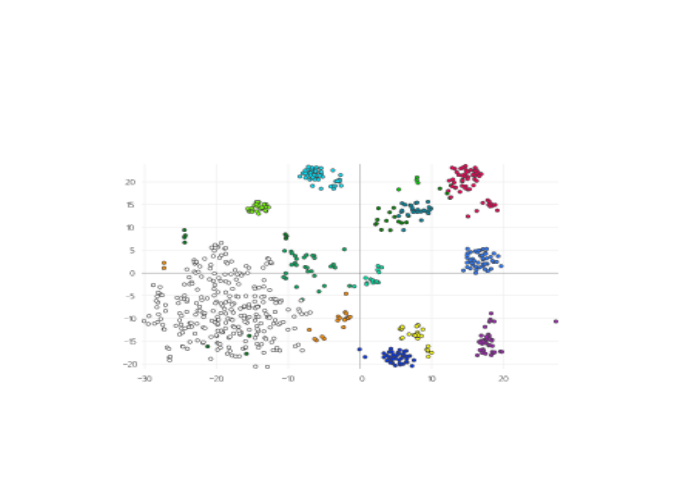

In [15]:
twodim = model.two_dim()
data = model.plot_trace()

py.image.ishow({'data': data})
# uncomment this line below (and comment the one above) to have the interactive plot
# py.iplot(data)